**Tutorial 3: Train SimCLR on Clothing**

https://docs.lightly.ai/tutorials/package/tutorial_simclr_clothing.html

***

***

# Imports

In [1]:
import os
import torch
import torch.nn as nn
import torchvision
import pytorch_lightning as pl
import lightly
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
from PIL import Image
import numpy as np

/home/sfandres/Documents/Git/lulc/lulc-venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


***

***

# Configuration

In [2]:
# Training setup.
num_workers = 8
batch_size = 256
seed = 1
max_epochs = 20
input_size = 128
num_ftrs = 32

# Replicability.
pl.seed_everything(seed)

# Path to dataset.
path_to_data = 'datasets/clothing-dataset/images'

Global seed set to 1


***

***

# Setup data augmentations and loaders

The images from the dataset have been taken from above when the clothing was on a table, bed or floor. Therefore, we can make use of additional augmentations such as vertical flip or random rotation (90 degrees). By adding these augmentations we learn our model invariance regarding the orientation of the clothing piece. E.g. we don’t care if a shirt is upside down but more about the strcture which make it a shirt.

In [3]:
collate_fn = lightly.data.SimCLRCollateFunction(
    input_size=input_size,
    vf_prob=0.5,
    rr_prob=0.5
)

# We create a torchvision transformation for
# embedding the dataset after training.
test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((input_size, input_size)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=lightly.data.collate.imagenet_normalize['mean'],
        std=lightly.data.collate.imagenet_normalize['std'],
    )
])

dataset_train_simclr = lightly.data.LightlyDataset(
    input_dir=path_to_data
)

dataset_test = lightly.data.LightlyDataset(
    input_dir=path_to_data,
    transform=test_transforms
)

dataloader_train_simclr = torch.utils.data.DataLoader(
    dataset_train_simclr,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    drop_last=True,
    num_workers=num_workers
)

dataloader_test = torch.utils.data.DataLoader(
    dataset_test,
    batch_size=batch_size,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

***

***

# Create the SimCLR Model

Now we create the SimCLR model. We implement it as a PyTorch Lightning Module and use a ResNet-18 backbone from Torchvision. Lightly provides implementations of the SimCLR projection head and loss function in the SimCLRProjectionHead and NTXentLoss classes. We can simply import them and combine the building blocks in the module.

In [4]:
from lightly.models.modules.heads import SimCLRProjectionHead
from lightly.loss import NTXentLoss


class SimCLRModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        # create a ResNet backbone and remove the classification head
        resnet = torchvision.models.resnet18()
        self.backbone = nn.Sequential(*list(resnet.children())[:-1])

        hidden_dim = resnet.fc.in_features
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)

        self.criterion = NTXentLoss()

    def forward(self, x):
        h = self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(h)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = torch.optim.SGD(
            self.parameters(), lr=6e-2, momentum=0.9, weight_decay=5e-4
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optim, max_epochs
        )
        return [optim], [scheduler]

In [5]:
gpus = 1 if torch.cuda.is_available() else 0

model = SimCLRModel()
trainer = pl.Trainer(
    max_epochs=max_epochs, gpus=gpus
)
trainer.fit(model, dataloader_train_simclr)

/home/sfandres/Documents/Git/lulc/lulc-venv/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params
---------------------------------------------------------
0 | backbone        | Sequential           | 11.2 M
1 | projection_head | SimCLRProjectionHead | 328 K 
2 | criterion       | NTXentLoss           | 0     
---------------------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.019    Total estimated model params size (MB)
/home/sfandres/Docume

Epoch 19: 100%|█████████████████████████████████████| 22/22 [00:09<00:00,  2.31it/s, loss=5.17, v_num=2]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|█████████████████████████████████████| 22/22 [00:09<00:00,  2.28it/s, loss=5.17, v_num=2]


In [6]:
def generate_embeddings(model, dataloader):
    """Generates representations for all images in the dataloader with
    the given model
    """

    embeddings = []
    filenames = []
    with torch.no_grad():
        for img, label, fnames in dataloader:
            img = img.to(model.device)
            emb = model.backbone(img).flatten(start_dim=1)
            embeddings.append(emb)
            filenames.extend(fnames)

    embeddings = torch.cat(embeddings, 0)
    embeddings = normalize(embeddings)
    return embeddings, filenames

model.eval()
embeddings, filenames = generate_embeddings(model, dataloader_test)

***

***

# Visualize Nearest Neighbors

In [7]:
def get_image_as_np_array(filename: str):
    """Returns an image as an numpy array
    """
    img = Image.open(filename)
    return np.asarray(img)


def plot_knn_examples(embeddings, filenames, n_neighbors=4, num_examples=6):
    """Plots multiple rows of random images with their nearest neighbors
    """
    # lets look at the nearest neighbors for some samples
    # we use the sklearn library
    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(embeddings)
    distances, indices = nbrs.kneighbors(embeddings)

    # get 5 random samples
    samples_idx = np.random.choice(len(indices), size=num_examples, replace=False)

    # loop through our randomly picked samples
    for idx in samples_idx:
        fig = plt.figure()
        # loop through their nearest neighbors
        for plot_x_offset, neighbor_idx in enumerate(indices[idx]):
            # add the subplot
            ax = fig.add_subplot(1, len(indices[idx]), plot_x_offset + 1)
            # get the correponding filename for the current index
            fname = os.path.join(path_to_data, filenames[neighbor_idx])
            # plot the image
            plt.imshow(get_image_as_np_array(fname))
            # set the title to the distance of the neighbor
            ax.set_title(f'd={distances[idx][plot_x_offset]:.3f}')
            # let's disable the axis
            plt.axis('off')

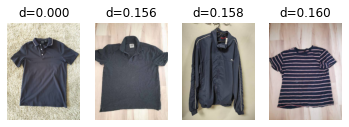

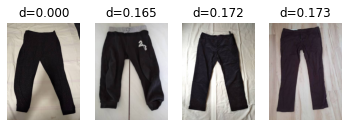

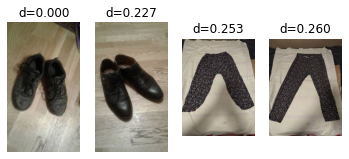

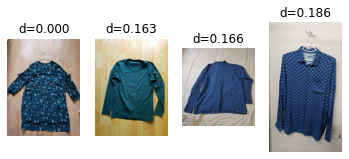

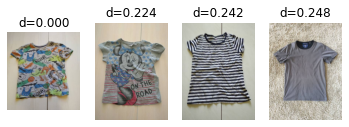

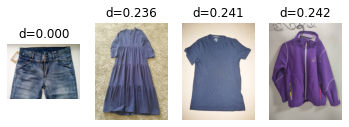

In [8]:
plot_knn_examples(embeddings, filenames)

In [9]:
# # You could use the pre-trained model and train a classifier on top.
# pretrained_resnet_backbone = model.backbone

# # you can also store the backbone and use it in another code
# state_dict = {
#     'resnet18_parameters': pretrained_resnet_backbone.state_dict()
# }
# torch.save(state_dict, 'model.pth')

In [10]:
# # load the model in a new file for inference
# resnet18_new = torchvision.models.resnet18()

# # note that we need to create exactly the same backbone in order to load the weights
# backbone_new = nn.Sequential(*list(resnet18_new.children())[:-1])

# model2 = torch.load('model.pth')
# backbone_new.load_state_dict(model2['resnet18_parameters'])

# model2.eval()

In [11]:
torch.save(model, 'model.pth')

In [12]:
model2 = torch.load('model.pth')
model2.eval()

SimCLRModel(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [13]:
embeddings2, filenames2 = generate_embeddings(model2, dataloader_test)

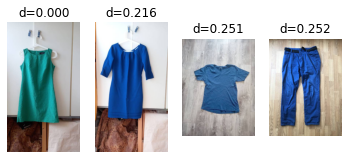

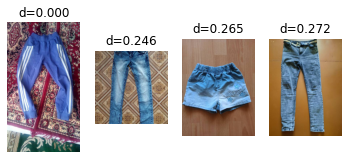

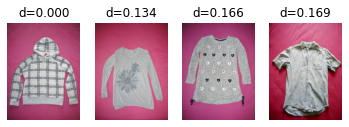

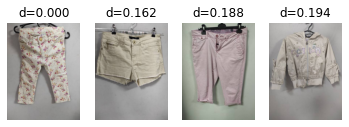

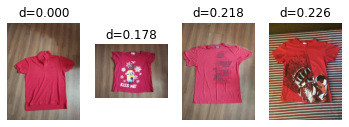

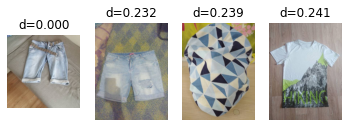

In [14]:
plot_knn_examples(embeddings2, filenames2)